From the file phase1_import_tweets.py I imported 34339 tweets that contains any of these words Russia, Ukraine, or #UkraineRussiaWar.

#### Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn  as sns
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # 1. Raw Data

#### Read raw Data to a Dataframe
After importing the tweets using the Twitter API in the import_tweets_hashtag.py file, we will read it using a dataframe, and check the shape and the missing data on the raw data

In [2]:
raw_df = pd.read_csv('./data/raw_data.csv')
#raw_df.sample(10)
raw_df.shape

(26000, 17)

<AxesSubplot:>

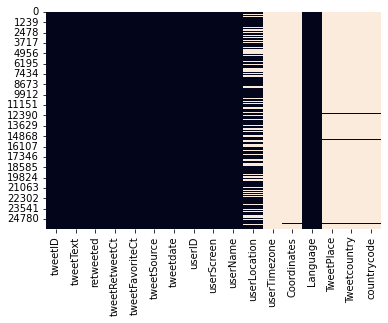

In [3]:
sns.heatmap(raw_df.isnull(), cbar=False)

#### Find and delete the duplicate tweets

In [4]:
raw_df.tweetText.value_counts()

@Steam @Steam\n\n BLOCK Russia #StopWarInUkraine #StopRussia                                                                                    6
@nytimes Still very far from making a scratch on Putin. He continues to bomb Ukraine.\n#Embargo on Russian Oil and Gas                          5
@NATO close the sky over #Ukraine!\n#StopRussianAggression #StopWarInUkraine #StopRussia #StopPutin                                             4
@BostonDynamics @SamuelAdamsBeer STOP RUSSIAN AGGRESSION AGAINST #UKRAINE. Ukraine need your help 🙏\n#StandWithUkriane #StopRussianAgression    3
@Ukraine Every Entertainment Platform should be banned for russia                                                                               3
                                                                                                                                               ..
Hungary will not allow lethal weapons for Ukraine to transit its territory - FM\nhttps://t.co/R31sKP0JSP                    

In [5]:
raw_df['duplicattweet'] = raw_df.duplicated(subset=['tweetText'], keep='first')

In [6]:
raw_df.duplicattweet.value_counts()

False    25957
True        43
Name: duplicattweet, dtype: int64

In [7]:
raw_df.drop(raw_df[raw_df.duplicattweet == True].index, inplace=True)
raw_df.duplicattweet.value_counts()

False    25957
Name: duplicattweet, dtype: int64

#### Chage the tweetdate column to datetime and extract only date to another column 

In [8]:
raw_df['tweetdate'] = pd.to_datetime(raw_df['tweetdate'])
raw_df['date'] = raw_df['tweetdate'].dt.date

In [9]:
raw_df.date.value_counts()

2022-02-28    25957
Name: date, dtype: int64

In [10]:
tweet_df = raw_df[['tweetText','tweetdate','date']]
tweet_df.shape

(25957, 3)

In [10]:
raw_df['Tweetcountry'].isnull().sum()

25635

# 2. Cleaning Process

#### Data Dictionary 

| Syntax                | Description |
| -----------           | ----------- |
|- tweetID :            | The unique identifier for Tweet. The dataset contain 34339 uniq tweets | 
|- tweetText :          | The actual text of the tweet |
|- tweetRetweetCt :     | Number of times this Tweet has been retweeted|
|- tweetFavoriteCt:     | Indicates approximately how many times this Tweet has been liked by Twitter users |
|- tweetCreated:        | UTC time when this Tweet was created  |
|- userID:              | The user ID who posted this Tweet |
|- userName:            | The user Name who posted this Tweet |
|- userLocation:        | The location of the user  |
|- Tweetcountry:        | The location of the user  |

#### Fill the missing of user location with tweet country

The process of obtaining country code is depend on the userlocation colume. it goes through long process 
I used the country_code.csv to create a dictionary 

In [ ]:
tweet_df = raw_df[['tweetText','tweetdate','date']]

Set xx value (Not Defined) in countrycode to all rows that have missing vlaue in both countrycode & userLocation

In [ ]:
import csv
with open('./data/country_code.csv', mode='r') as inp:
    reader = csv.reader(inp)
    code_dic = {rows[0]:rows[1] for rows in reader}

code_dic['Not Defined'] = 'XX'
#print(code_dic)

In [ ]:
tweet_df[tweet_df['countrycode'].isnull() & tweet_df['userLocation'].isnull()]['userLocation']

Set all null value in both countrycode and userLocation to Not Defined 

In [ ]:
tweet_df['countrycode'] = np.where(tweet_df['countrycode'].isnull() & tweet_df['userLocation'].isnull(), code_dic.get('Not Defined'), tweet_df['countrycode'])

In [ ]:
tweet_df['userLocation'].nunique

Check all null value in countrycode but has a value in userLocation

In [ ]:
country_dic = { 'Not Defined'   : 'Mountains|WORLD|worlds|elsewhere|文科省と厚労省の狭間|stupid|worldwide|said|Men|Matter|Heart|.com|Asia Pacific|Street|@|Stolen|Ponamogoatitjg|Frozen tundra North|/|Trumpsylvania|by way|Hotel|your|upset|San Sebastian|Unknown|Galaxy|Internet|Vaccinated|Metro|Meta|internet|Some Where|INCOME|gritty|Earth|Between|SAG/AFTRA|美丽的大麻猫岛|Wschód|MV1|iPhone|BIO|Imo|Here|since|Дитина Світу|Chinadastan|NEWSLETTER|Text|They|DMV|World|Query hell|22|🕳️🐇|Free|free|Happy Valley|Alba gu bràth|The World|Somewhere|christmas town|𝔦𝔫𝔣𝔢𝔯𝔫𝔞𝔩|Astronesia|Schuylkill Haven|Bedroom|Autumn|21|Mom|Nebula|Lissachan|Django|coming soon|Wherever|exile|Home|Any pronouns|Metaverse|http://|area 51|La Isla Bonita|Not|home',
                'United States' : 'United States|American|US|Miami|USA|LA|Atlanta|Philadelphia|Poughkeepsie|Albany, GA|carolina|Carol Stream, IL|Cape Coral, FL|brooklyn|L.A|Klamath Falls, OR|Westchester County, NY|Deadwood, SD|Baltimore|washington, dc|Brooklyn|Fort Wayne, IN|Seattle|Deep South|East Louisville KY|Myrtle Beach, SC|Highlands Ranch, CO|Sayre, PA|Portland, OR|U.S.A|nyc|Austin, TX|Austin, Tx|Newton, NJ|Nashville, TN|Kailua, HI|Manhattan, NY|HARLEM, NY|Eugene, OR|Dallas, TX|HARLEM, NY|Mansfield, MA|Central IL|Littleton, CO|Miami, FL|new york city|Fort Worth|Gig Harbor, WA|Chicago|Syracuse, NY|Sacramento, Ca|Atlanta, GA|Lansing, MI|Newark, NJ|Palermo, NJ|Philadelphia, PA|kansas|Charlotte, NC|Birmingham, AL|Alabama|AlaskaArizona|Arkansas|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New Hampshire|New Jersey|New Mexico|New York|North Carolina|North Dakota|Ohio|Oklahoma|Oregon|Pennsylvania|Rhode Island|South Carolina|South Dakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West Virginia|Wisconsin|Wyoming|Holtsville, NY|Adjuntas, PR|Aguada, PR|Aguadilla, PR|Maricao, PR|Anasco, PR|Angeles, PR|Arecibo, PR|Bajadero, PR|Barceloneta, PR|Boqueron, PR|Cabo Rojo, PR|Penuelas, PR|Camuy, PR|Castaner, PR|Rosario, PR|Sabana Grande, PR|	Ciales, PR|	Utuado, PR|	Dorado, PR|Ensenada, PR|Florida, PR|Garrochales, PR|Guanica, PR|Guayanilla, PR|Hatillo, PR|Hormigueros, PR|Isabela, PR|Jayuya, PR|Lajas, PR|Lares, PR|Las Marias, PR|Manati, PR|	Moca, PR|Rincon, PR|Quebradillas, PR|Mayaguez, PR|San German, PR|San Sebastian, PR|	Morovis, PR|Sabana Hoyos, PR|San Antonio, PR|Vega Alta, PR|Vega Baja, PR|Yauco, PR|Aguas Buenas, PR|Aguirre, PR|Aibonito, PR|Maunabo, PR|Arroyo, PR|	Mercedita, PR|Ponce, PR|Naguabo, PR|Naranjito, PR|Orocovis, PR|Palmer, PR|Patillas, PR|Caguas, PR|Canovanas, PR|Ceiba, PR|Cayey, PR|Fajardo, PR|Cidra, PR|Puerto Real, PR|Punta Santiago, PR|Roosevelt Roads, PR|Rio Blanco, PR|Rio Grande, PR|Salinas, PR|San Lorenzo, PR|Santa Isabel, PR|Vieques, PR|Villalba, PR|Yabucoa, PR|Coamo, PR|Las Piedras|Loiza, PR|Luquillo, PR|Culebra, PR|Juncos, PR|Gurabo, PR|Coto Laurel, PR|Comerio, PR|Corozal, PR|Guayama, PR|La Plata, PR|Humacao, PR|Barranquitas, PR|Juana Diaz, PR|St Thomas, VI|Christiansted, VI|St John, VI|Frederiksted, VI|Kingshill, VI|San Juan, PR|Fort Buchanan, PR|GPO, PR|Toa Baja, PR|Sabana Seca, PR|Toa Alta, PR|Bayamon, PR|Catano, PR|Guaynabo, PR|Trujillo Alto, PR|Saint Just, PR|Carolina, PR|Agawam, MA|Amherst, MA|Barre, MA|Belchertown, MA|Blandford, MA|Bondsville, MA|Brimfield, MA|Chester, MA|Chesterfield, MA|Chicopee, MA|Cummington, MA|	Easthampton, MA|East Longmeadow, MA|East Otis, MA|Feeding Hills, MA|Gilbertville, MA|Goshen, MA|Granby, MA|Granville, MA|Hadley, MA|Hampden, MA|Hardwick, MA|Hatfield, MA|Haydenville, MA|Holyoke, MA|Huntington, MA|Leeds, MA|Leverett, MA|Ludlow, MA|Monson, MA|North Amherst, MA|Northampton, MA|Florence, MA|North Hatfield, MA|Oakham, MA|Palmer, MA|Plainfield, MA|Russell, MA|Shutesbury, MA|Southampton, MA|South Barre, MA|Hadley, MA|Southwick, MA|Thorndike, MA|Three Rivers, MA|Wales, MA|Ware, MA|Warren, MA|West Chesterfield, MA|Westfield, MA|West Hatfield, MA|West Springfield, MA|	West Warren, MA|Whately, MA|Wheelwright, MA|Wilbraham, MA|Williamsburg, MA|Woronoco, MA|Worthington, MA|Springfield, MA|Longmeadow, MA|Indian Orchard, MA|Pittsfield, MA|Adams, MA|Ashley Falls, MA|Becket, MA|Berkshire, MA|Cheshire, MA|Dalton, MA|Glendale, MA|Great Barrington, MA|Hinsdale, MA|Housatonic, MA|Lanesboro, MA|Lee, MA|Lenox, MA|Lenox Dale, MA|Middlefield, MA|Mill River, MA|Monterey, MA|North Adams, MA|North Egremont, MA|Otis, MA|Richmond, MA|Sandisfield, MA|Savoy, MA|Sheffield, MA|South Egremont, MA|Southfield, MA|South Lee, MA|Stockbridge, MA|Tyringham, MA|West Stockbridge, MA|Williamstown, MA|Windsor, MA|Greenfield, MA|	Ashfield, MA|Athol, MA|Bernardston, MA|Buckland, MA|Charlemont, MA|Colrain, MA|Conway, MA|Deerfield, MA|Drury, MA|Erving, MA|Heath, MA|Lake Pleasant, MA|Millers Falls, MA|Monroe Bridge, MA|Montague, MA|Gill, MA|New Salem, MA|Northfield, MA|Orange, MA|Petersham, MA|Rowe, MA|Royalston, MA|Shelburne Falls, MA|South Deerfield, MA|Sunderland, MA|Turners Falls, MA|Warwick, MA|Wendell, MA|Wendell Depot, MA|Fitchburg, MA|Ashburnham, MA|Ashby, MA|Ayer, MA|Devens, MA|Baldwinville, MA|East Templeton, MA|Gardner, MA|Westminster, MA|Groton, MA|Harvard, MA|Hubbardston, MA|Leominster, MA|Littleton, MA|Lunenburg, MA|Pepperell, MA|Shirley, MA|Still River, MA|Templeton, MA|Townsend, MA|West Groton, MA|West Townsend, MA|Winchendon, MA|Winchendon Springs, MA|Auburn, MA|Berlin, MA|Blackstone, MA|Boylston, MA|Brookfield, MA|Charlton, MA|Charlton City, MA|Charlton Depot, MA|Clinton, MA|East Brookfield, MA|	Douglas, MA|East Princeton, MA|Fiskdale, MA|Grafton, MA|Holden, MA|Holland, MA|Jefferson, MA|Lancaster, MA|Leicester, MA|Linwood, MA|Manchaug, MA|Millbury, MA|Millville, MA|New Braintree, MA|Northborough,MA|Northbridge, MA|North Brookfield|, MA|, AL|, AK|, AZ|, AR|, CA|, CO|, CT|, DE|, FL|, GA|, HI|, ID|, IL|, IN|, IA|, KS|, KY|, LA|, ME|, MD|, MA|, MI|, MN|, MS|, MO|, MT|, NE|, NV|, NH|, NJ|, NM|, NY|, NC|, ND|, OH|, OK|, OR|, PA|, RI|, SC|, SD|, TN|, TX|, UT|, VT|, VA|, WA|, WV|, WI|, WY|, al|, ak|, az|, ar|, ca|, co|, ct|, de|, fl|, ga|, hi|, id|, il|, in|, ia|, ks|, ky|, la|, me|, md|, ma|, mi|, mn|, ms|, mo|, mt|, ne|, nv|, nh|, nj|, nm|, ny|, nc|, nd|, oh|, ok|, or|, pa|, ri|, sc|, sd|, tn|, tx|, ut|, vt|, va|, wa|, wv|, wi|, wy',
                'Canada'   : 'Canada|CA|Ontario|Mississauga|Montréal, Québec|Halifax|Tkoronto|Toronto|Cape Breton|Edmonton|Alberta|Victoria|Tkoronto|Nunavut|Quebec|Northwest Territories|Ontario|British Columbia|Alberta|Saskatchewan|Manitoba|Yukon|Newfoundland and Labrador|New Brunswick|Nova Scotia|Prince Edward Island|Ottawa',
                'United Kingdom' : 'United Kingdom|England|Lincolnshire|Midwest|Great Basin Kingdom|South East, England|Manchester, England|Manchester|British Isles|London|UK|Great Britain|Nottingham|U K|Scotland|Livingston|Aberconwy and Colwyn|Aberdeen City|Aberdeenshire|Anglesey|Angus|Antrim|Argyll and Bute|Armagh|Avon|Ayrshire|Bath and NE Somerset|Bedfordshire|Belfast|Berkshire|Berwickshire|BFPO|Blaenau Gwent|Buckinghamshire|Caernarfonshire|Caerphilly|Caithness|Cambridgeshire|Cardiff|Cardiganshire|Carmarthenshire|Ceredigion|Channel Islands|Cheshire|City of Bristol|Clackmannanshire|Clwyd|Conwy|Cornwall/Scilly|Cumbria|Denbighshire|Derbyshire|Derry/Londonderry|Devon|Dorset|Down|Dumfries and Galloway|Dunbartonshire|Dundee|Durham|Dyfed|East Ayrshire|East Dunbartonshire|East Lothian|East Renfrewshire|East Riding Yorkshire|East Sussex|Edinburgh|England|Essex|Falkirk|Fermanagh|Fife|Flintshire|Glasgow|Gloucestershire|Greater London|Greater Manchester|Gwent|Gwynedd|Hampshire|Hartlepool|Hereford and Worcester|Hertfordshire|Highlands|Inverclyde|Inverness-Shire|Isle of Man|Isle of Wight|Kent|Kincardinshire|Kingston Upon Hull|Kinross-Shire|Kirklees|Lanarkshire|Lancashire|Leicestershire|Lincolnshire|Londonderry|Merseide|Merthyr Tydfil|Mid Glamorgan|Mid Lothian|Middlesex|Monmouthshire|Moray|Neath & Port Talbot|Newport|Norfolk|North Ayrshire|North East Lincolnshire|North Lanarkshire|North Lincolnshire|North Somerset|North Yorkshire|Northamptonshire|Northern Ireland|Northumberland|Nottinghamshire|Orkney and Shetland Isles|Oxfordshire|Pembrokeshire|Perth and Kinross|Powys|Redcar and Cleveland|Renfrewshire|Rhonda Cynon Taff|Rutland|Scottish Borders|Shetland|Shropshire|Somerset|South Ayrshire|South Glamorgan|South Gloucesteshire|South Lanarkshire|South Yorkshire|Staffordshire|Stirling|Stockton On Tees|Suffolk|Surrey|Swansea|Torfaen|Tyne and Wear|Tyrone|Vale Of Glamorgan|Wales|Warwickshire|West Berkshire|West Dunbartonshire|West Glamorgan|West Lothian|West Midlands|West Sussex|West Yorkshire|Western Isles|Wiltshire|Wirral|Worcestershire|Wrexham|York',
                'Indonesia'  : 'Indonesia|Jakarta|Surabaya',
                'Ukraine' : 'Ukraine|Украина|Кривий Ріг|Kryvyi Rih|Україна|Krivoy Rog|Snake Island|Kiev|Kyiv|Київ|Харків|Kharkiv|Odesa|Одеса|Dnipro|Дніпро|Donetsk|Донецьк|Cherkasy|Chernihiv|Chernivtsi|Dnipropetrovsk|Donetsk|Ivano-Frankivsk|Kharkiv|Kherson|Khmelnytskyi|Kiev|Kirovohrad|Luhansk|Lviv|Mykolaiv|Odessa|Poltava|Rivne|Sumy|Ternopil|Vinnytsia|Volyn|Zakarpattia|Zaporizhia|Zhytomyr',
                'Poland' : 'Poland|Kraków|Warszawa|wielkopolskie|Greater Poland|kujawsko-pomorskie|małopolskie|łódzkie|Kuyavia-Pomerania|Lesser Poland|Łódź',
                'India' : 'India|New Delhi|Hyderabad|Mumbai|Punjab|Pune',
                'Germany' : 'Germany|Berlin|Bayern|Bavaria|Niedersachsen|Lower Saxony|Baden-Württemberg|Rheinland-Pfalz|Rhineland-Palatinate|Sachsen|Saxony|Thüringen|Thuringia|Hessen|Nordrhein-Westfalen|North Rhine-Westphalia|Sachsen-Anhalt|Saxony-Anhalt|Brandenburg|Mecklenburg-Vorpommern|Hamburg|Schleswig-Holstein|Saarland|Bremen|Munich, Bavaria|Munich|Düsseldorf',
                'Saudi Arabia' : 'المملكة العربية السعودية|Kingdom of Saudi Arabia|Saudi Arabia|KSA|Jeddah|Makkah|Riyadh',
                'Slovenia' : 'Slovenia|Ljubljana|Slovenija|Osrednjeslovenska|Littoral–Inner|Mura|Pomurska|Drava|Podravska|Koroška|Carinthia',
                'Switzerland' : 'Switzerland|Zurich|Basel|Geneva|Swiss|Zürich|Bern|Berne|Luzern|Uri|Schwyz|Unterwalden|Nidwalden|Glarus|Zug',
                'Yemen':'اليمن|Yaman|Yemen',
                'Turkey': 'Turkey|Ankara|Istanbul|İzmir|Antalya',
                'Uganda': 'Uganda|Kampala|Nansana|Kira|Mbarara',
                'Portugal' : 'Portugal|Porto|Amadora|Lisbon|Braga',
                'Australia' : 'Australia|Sydney|Katoomba|Melbourne|vienna|australia|Canberra',
                'Ireland' : 'Ireland|Dublin|Cork|Limerick|Galway|Waterford|Dunshaughlin',
                'Nigeria' : 'Nigeria|Lagos|Kano|Oyo|Edo|Abuja',
                'New Zealand' : 'New Zealand|Central Hawke|Auckland|Christchurch|Wellington|Hamilton|Tauranga',
                'Finland' : 'Finland|Jyväskylä|Helsinki|Oulu',
                'Argentina': 'Argentina|Buenos Aires|Cordoba|Rosario|Mendoza|La Plata|Tucumán',
                'Czech Republic' : 'Czech Republic|Brno|Ostrava|Prague',
                'Netherlands' : 'Netherlands|Amsterdam|Drenthe|Flevoland|Friesland|Gelderland|Groningen|Limburg|North Brabant|North Holland|Overijssel|Zeeland|Utrecht|South Holland|Gouda|Turfmarkt|Hague|',
                'Morocco' : 'Morocco|Casablanca|Fez|Tangier|Marrakesh|Tanger',
                'France' : 'France|Le Mans|Paris|Marseille|Lyon|Toulouse|Crozet',
                'Brazil' : 'Brazil|isla miel|São Paulo|Brasília|Brasil',
                'Nigeria' : 'Nigeria|Yobe|Maiduguri|Yobe, Maiduguri',
                'Russian Federation' : 'Russia|Moscow|Saint Petersburg|Novosibirsk|Austin|Saint Petersburg|Khanty-Mansiysk|belgorod,russia',
                'China' : 'China|Beijing|Hong Kong',
                'Ethiopia' : 'Ethiopia|ቤቴ|Addis Ababa|Mekelle|Gondar|Adama',
                'Belgium' :'Belgium|België|Brussels',
                'Malaysia' : 'Malaysia|Kuala Lumpur',
                'Slovakia' : 'Slovakia',
                'Italy' : 'Italy|Italia|Como|Calabria|Pavia|Venice|Rome|Romania',
                'Azerbaijan' : 'Azerbaijan|Shushi',
                'Spain' : 'Spain|Tenerife|Mallorca|Gran Canaria|Lanzarote|Ibiza|Fuerteventura|Menorca|La Palma|La Gomera|Formentera|El Hierro',
                'Jamaica' : 'Jamaica',
                'Bangladesh' :'Bangladesh|bangladesh|Dhaka|BANGLADESH',
                'Czech Republic' : 'Czechia|Czech Republic|Czech',
                'Egypt' : 'Egypt|cairo|Cairo|Alexandria'
                }


In [ ]:
print(tweet_df[tweet_df['countrycode'].isnull() & tweet_df['userLocation'].notnull()]['userLocation'])

In [ ]:
tweet_df.userLocation.value_counts()

In [ ]:
Key_word = 'Not Defined'
country_key = Key_word
country_Name = country_dic[Key_word]
print(code_dic.get(country_key))

In [ ]:
tweet_df[tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull()]['userLocation']

In [ ]:
tweet_df['countrycode'] = np.where(tweet_df['userLocation'].str.contains(country_Name,na=False) & tweet_df['countrycode'].isnull(), code_dic.get(country_key), tweet_df['countrycode'])

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,10))
ax = sns.countplot(x="countrycode", data=tweet_df, order = tweet_df['countrycode'].value_counts().index)

In [ ]:
tweet_df.countrycode.isnull().sum()

In [ ]:
tweet_df.countrycode.value_counts()

## Text Pre-Processing

In [11]:
#tweet_df = pd.read_csv('./data/cleaned_data.csv')
tweet_df = raw_df[['tweetText','tweetdate','date']]

In [ ]:
tweet_df['tweetText'].head()

In [12]:
# source: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [13]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
    
tweet_df['cleanText'] = tweet_df['tweetText'].apply(lambda x: finalpreprocess(x))
tweet_df.head()

/tmp/ipykernel_416/3883534920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['cleanText'] = tweet_df['tweetText'].apply(lambda x: finalpreprocess(x))


,tweetText,tweetdate,date,cleanText
0,@RealPepeEscobar Flush those fancy degrees dow...,2022-02-28 22:32:28+00:00,2022-02-28,realpepeescobar flush fancy degree toilet saw ...
1,"Hey @GrantRandom, while listening to @SXMOctan...",2022-02-28 22:32:28+00:00,2022-02-28,hey grantrandom listen sxmoctane late last nig...
2,Stephen King stands with #Ukraine!\n@StephenKi...,2022-02-28 22:32:28+00:00,2022-02-28,stephen king stand ukraine stephenking stephen...
3,@kilogolfsierra @form_whisperer @EdwardGLuce U...,2022-02-28 22:32:28+00:00,2022-02-28,kilogolfsierra form whisperer edwardgluce ukra...
4,@indiana_imo It's because Russia is a nuclear ...,2022-02-28 22:32:28+00:00,2022-02-28,indiana imo russia nuclear superpower aggressi...


In [14]:

stop_words = set(stopwords.words('english'))
additional_stopwords = {'I','-','&map','would','this', 'we','the', 'you', 'co', 'http', 'https'}
stop_words.update(additional_stopwords)
#type(stop_words)
#print(stop_words)

# STOPWORD REMOVAL
def removestopword(string):
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

def remove_url(text_data):
      """remove_url takes raw text and removes urls from the text.
         https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
         """
      return re.sub(r"http\S+", "", text_data)


lem = WordNetLemmatizer()

def lem_text(text_data):
        """lem_text takes text and lemmatize it using WordNetLemmatizer.
            ref: https://stackoverflow.com/a/25535348"""

        n_text = []
        for word in text_data.split(' '):
            n_word = lem.lemmatize(word, pos='a')
            n_word = lem.lemmatize(n_word, pos='v')
            n_text.append(n_word)

        return ' '.join(n_text)

In [15]:
tweet_df['cleanText'] = tweet_df['cleanText'].apply(lambda x: removestopword(x))

/tmp/ipykernel_416/2460791469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['cleanText'] = tweet_df['cleanText'].apply(lambda x: removestopword(x))


In [16]:
from collections import Counter
Counter(" ".join(tweet_df['cleanText']).split()).most_common(20)

[('ukraine', 13184),
 ('russia', 8878),
 ('russian', 2784),
 ('putin', 2685),
 ('war', 2222),
 ('u', 2145),
 ('people', 1630),
 ('nato', 1362),
 ('say', 1345),
 ('go', 1294),
 ('world', 1058),
 ('get', 1039),
 ('invasion', 957),
 ('ukrainian', 954),
 ('think', 916),
 ('country', 906),
 ('support', 893),
 ('like', 881),
 ('want', 849),
 ('help', 828)]

### Extracting vectors from text (Vectorization)

In [17]:
import re
import string

def countWords(data_frame, selected_words):
    words_dict = {}
    
    for sentence in data_frame:
        remove = string.punctuation
        remove = remove.replace("'", "") # don't remove hyphens
        pattern = r"[{}]".format(remove) # create the pattern

        test = re.sub(pattern, "", str(sentence)) #compile

        splited_words = str(test).split(' ')

        for word in splited_words:
            word = word.strip()
            word = word.lower()
            if word in selected_words:
                if word not in words_dict:
                    words_dict[word] = 1
                else:
                    words_dict[word] += 1
    return words_dict

In [18]:
import pycountry
countries_list = []
for country in pycountry.countries:
     countries_list.append(country.name.lower())
countries_list.append('russia')
countries_list.append('us')
countries_list.append('england')
countries_list.append('saudi')

In [19]:
import operator
extracted_countries = countWords(tweet_df['cleanText'],countries_list)
dict(sorted(extracted_countries.items(), key=operator.itemgetter(1),reverse=True))

{'ukraine': 13184,
 'russia': 8878,
 'china': 381,
 'poland': 262,
 'canada': 252,
 'israel': 183,
 'belarus': 181,
 'germany': 115,
 'turkey': 98,
 'iraq': 95,
 'india': 81,
 'afghanistan': 72,
 'finland': 70,
 'switzerland': 57,
 'ireland': 54,
 'nigeria': 47,
 'france': 46,
 'hungary': 40,
 'sweden': 34,
 'georgia': 32,
 'australia': 29,
 'libya': 28,
 'jordan': 26,
 'cuba': 24,
 'serbia': 24,
 'yemen': 24,
 'japan': 24,
 'bulgaria': 23,
 'romania': 23,
 'saudi': 22,
 'pakistan': 20,
 'latvia': 19,
 'brazil': 18,
 'monaco': 17,
 'mexico': 17,
 'qatar': 15,
 'somalia': 14,
 'us': 13,
 'estonia': 11,
 'norway': 11,
 'slovakia': 11,
 'lithuania': 11,
 'greece': 9,
 'armenia': 9,
 'egypt': 8,
 'ethiopia': 8,
 'azerbaijan': 8,
 'myanmar': 7,
 'italy': 6,
 'england': 6,
 'lebanon': 6,
 'peru': 6,
 'croatia': 6,
 'jersey': 6,
 'slovenia': 5,
 'cyprus': 5,
 'mali': 5,
 'kenya': 4,
 'argentina': 4,
 'kuwait': 4,
 'kazakhstan': 4,
 'singapore': 4,
 'netherlands': 4,
 'spain': 4,
 'congo': 4,


In [20]:
def target_country (row):
   if 'ukraine' in row['cleanText'] :
      return 'ukraine'
   elif 'russia' in row['cleanText']:
      return 'russia'
   else:
      return 'na'

In [21]:
tweet_df['target'] = tweet_df.apply (lambda row: target_country(row), axis=1)

/tmp/ipykernel_416/2262426310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['target'] = tweet_df.apply (lambda row: target_country(row), axis=1)


In [22]:
tweet_df.head()

,tweetText,tweetdate,date,cleanText,target
0,@RealPepeEscobar Flush those fancy degrees dow...,2022-02-28 22:32:28+00:00,2022-02-28,realpepeescobar flush fancy degree toilet saw ...,na
1,"Hey @GrantRandom, while listening to @SXMOctan...",2022-02-28 22:32:28+00:00,2022-02-28,hey grantrandom listen sxmoctane late last nig...,na
2,Stephen King stands with #Ukraine!\n@StephenKi...,2022-02-28 22:32:28+00:00,2022-02-28,stephen king stand ukraine stephenking stephen...,ukraine
3,@kilogolfsierra @form_whisperer @EdwardGLuce U...,2022-02-28 22:32:28+00:00,2022-02-28,kilogolfsierra form whisperer edwardgluce ukra...,ukraine
4,@indiana_imo It's because Russia is a nuclear ...,2022-02-28 22:32:28+00:00,2022-02-28,indiana imo russia nuclear superpower aggressi...,russia


In [23]:
ukraine_df = tweet_df.loc[(tweet_df['target'] == 'ukraine'), ['tweetText','cleanText']]
russia_df = tweet_df.loc[(tweet_df['target'] == 'russia'), ['tweetText','cleanText']]

In [25]:
#https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/
from nrclex import NRCLex

ukraine_text_list = ukraine_df['cleanText'].to_list()
ukraine_emotion = []
for i in range(len(ukraine_text_list)):
    ukraine_emotion.append(NRCLex(ukraine_text_list[i]))


russia_text_list = russia_df['cleanText'].to_list()
russia_emotion = []
for i in range(len(russia_text_list)):
    russia_emotion.append(NRCLex(russia_text_list[i]))

In [36]:
ukraine_emotion_dic = {}    
for i in range(len(ukraine_emotion)):
    ukraine_emotion_dic.update((ukraine_emotion[i]).raw_emotion_scores)
print(ukraine_emotion_dic)

{'positive': 1, 'fear': 3, 'negative': 4, 'sadness': 1, 'anger': 1, 'anticipation': 1, 'disgust': 1, 'surprise': 1, 'joy': 2, 'trust': 1}


In [35]:
russia_emotion_dic = {}    
for i in range(len(russia_emotion)):
    russia_emotion_dic.update((russia_emotion[i]).raw_emotion_scores)
print(russia_emotion_dic)

{'anger': 1, 'fear': 1, 'negative': 2, 'sadness': 1, 'surprise': 2, 'joy': 1, 'positive': 1, 'trust': 1, 'anticipation': 1, 'disgust': 1}


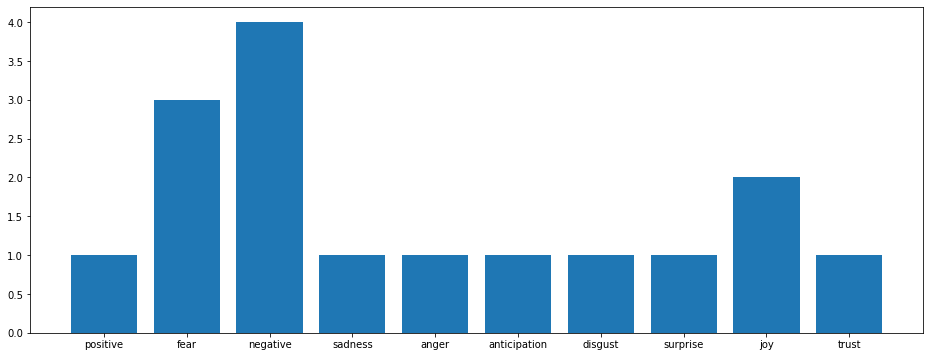

In [40]:
import matplotlib.pyplot as plt

plt.bar(range(len(ukraine_emotion_dic)), list(ukraine_emotion_dic.values()), align='center')
plt.xticks(range(len(ukraine_emotion_dic)), list(ukraine_emotion_dic.keys()))
plt.rcParams['figure.figsize'] = [20, 15]
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

In [30]:
print(len(russia_emotion))

7080


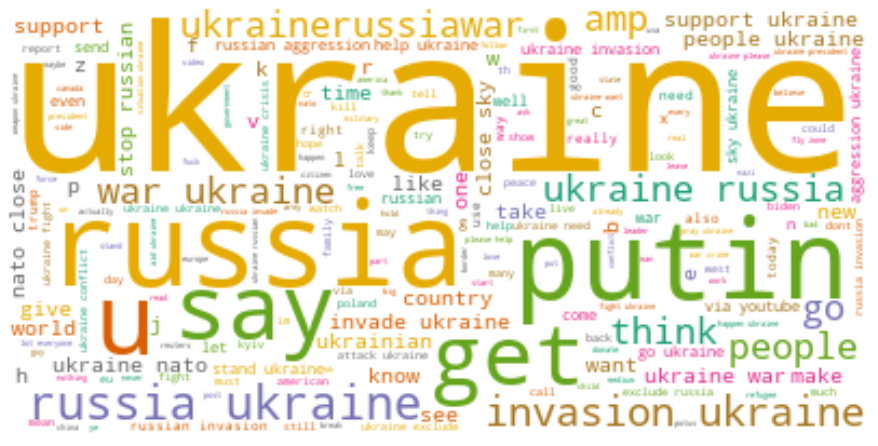

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

tweet_word = " ".join(title for title in ukraine_df.cleanText)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

-------------------------------------

In [ ]:
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['cleanText']), axis=1)

In [ ]:
sentence_df = tweet_df['tokenized_sentence']

In [ ]:
sentence_df

In [ ]:
# Divide to words and sentence
tweet_df['tokenized_words'] = tweet_df.apply(lambda row: nltk.word_tokenize(row['tweetText']), axis=1)
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['tweetText']), axis=1)

In [ ]:
stemmer = SnowballStemmer("english")
tweet_df['stemmed_sentence'] = tweet_df['tokenized_sentence'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

In [ ]:
tweet_df['stemmed_sentence']

In [ ]:
tweet_df['tokenized_words']

In [ ]:
from collections import Counter
Counter(" ".join(tweet_df['tweetText']).split()).most_common(10)

In [ ]:
tweet_df['stemmed_sentence'][1]

In [ ]:
tweet_df[tweet_df('stemmed_sentence')]

In [ ]:
tweet_df['tweetText']=tweet_df['tweetText'].str.replace(' saudi ',' saudi arabia ')
tweet_df['tweetText']=tweet_df['tweetText'].str.replace(' us ',' united states ')

In [ ]:
tweet_df.loc[tweet_df['tweetText'].str.contains('us'),'tweetText'] = tweet_df['tweetText'].str.replace(' us ',' united states ')

In [ ]:
#replace us with united states 
tweet_df.loc[tweet_df['tweetText'].str.contains('united states')]

In [ ]:
import pycountry
countries_list = []
for country in pycountry.countries:
     countries_list.append(country.name.lower())
countries_list.append('russia')
countries_list.append('us')

In [ ]:
extracted_countries = countWords(tweet_df['tweetText'],countries_list)

In [ ]:
countries_list

In [ ]:
dict(sorted(extracted_countries.items(), key=lambda item: item[1]))

In [ ]:
countries = (country.name for country in pycountry.countries)


In [ ]:
print(countries)

In [ ]:
tweet_df[tweet_df['country_in_text'].notnull()]

In [ ]:
tweet_df[tweet_df['tweetText'].str.contains(' saudi arabia ',na=False)]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

tweet_word = " ".join(title for title in tweet_df.cleanText)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

All tweets contains ukraine but not russia

In [ ]:
included_word = 'saudi'
excluded_word = 'u'

tweet_word = " ".join(title for title in tweet_df[tweet_df['tweetText'].str.contains(included_word,na=False) & ~tweet_df['tweetText'].str.contains(excluded_word ,na=False)]['tweetText'])
plt.rcParams['figure.figsize'] = [10, 4]

cloud = wc.generate(tweet_word)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()

In [ ]:
# Divide to words and sentence
tweet_df['tokenized_words'] = tweet_df.apply(lambda row: nltk.word_tokenize(row['tweetText']), axis=1)
tweet_df['tokenized_sentence'] = tweet_df.apply(lambda row: nltk.sent_tokenize(row['tweetText']), axis=1)

In [ ]:
tweet_df['tokenized_words']

In [ ]:
tweet_df['tokenized_sentence']

#### Save Cleaned Data

Save the cleaned data to cleaned_data.csv

In [ ]:
tweet_df = tweet_df[['tweetID','tweetText','tweetdate','date','countrycode']]
# Overwrite or add
ans = input('Do you want overwrite the file? (y/n): ')
if (ans == 'y'):
    tweet_df.to_csv('./data/cleaned_data.csv', index=False)
else:  
    # check if the file exist, it will add the data 
    try:
        with open('./data/cleaned_data.csv') as f:
            print('Add The data to the existing file')
            tweet_df.to_csv('./data/cleaned_data.csv',mode='a', header=False, index=False)
    except IOError:
       print('Create new file')
       tweet_df.to_csv('./data/cleaned_data.csv', index=False)

In [ ]:
cleaned_tweet_df = pd.read_csv('./data/cleaned_data.csv')
cleaned_tweet_df.shape

In [ ]:
cleaned_tweet_df.head()

---------------------------------------------------------------------------------------------------

# Under Development  